In [ ]:
# Selecting Tensorflow version v2
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


**Download the Dataset**

In [ ]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1130496/1115394 [==============================] - 0s 0us/step
/tmp/.keras/datasets/shakespeare.txt


**Analyze the Data**

In [ ]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text.
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))

print('{} unique characters'.format(len(vocab)))
print('vocab:', vocab)

65 unique characters
vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Process Data


# Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [ ]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [ ]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)
print(index2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
# Convert chars in text to indices.
text_as_int = np.array([char2index[char] for char in text])

print('text_as_int length: {}'.format(len(text_as_int)))
print('{} --> {}'.format(repr(text[:15]), repr(text_as_int[:15])))

text_as_int length: 1115394
'First Citizen:\n' --> array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0])


# Create training sequences

In [ ]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 100
examples_per_epoch = len(text) // (sequence_length + 1)

print('examples_per_epoch:', examples_per_epoch)

examples_per_epoch: 11043


In [ ]:
# Create training dataset.
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for char in char_dataset.take(5):
    print(index2char[char.numpy()])

F
i
r
s
t


In [ ]:
# Generate batched sequences out of the char_dataset.
sequences = char_dataset.batch(sequence_length + 1, drop_remainder=True)

# Sequences size is the same as examples_per_epoch.
print('Sequences count: {}'.format(len(list(sequences.as_numpy_iterator()))));
print()

# Sequences examples.
for item in sequences.take(5):
    print(repr(''.join(index2char[item.numpy()])))

Sequences count: 11043

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text. For example, say sequence_length is 4 and our text is Hello. The input sequence would be Hell, and the target sequence ello.

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

# Dataset size is the same as examples_per_epoch.
# But each element of a sequence is now has length of `sequence_length`
# and not `sequence_length + 1`.
print('dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

dataset size: 11043


In [ ]:
for input_example, target_example in dataset.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:', repr(''.join(index2char[input_example.numpy()])))
    print('Target:', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 100
Target sequence size: 100

Input: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))

Step  0
  input: 18 ('F')
  expected output: 47 ('i')
Step  1
  input: 47 ('i')
  expected output: 56 ('r')
Step  2
  input: 56 ('r')
  expected output: 57 ('s')
Step  3
  input: 57 ('s')
  expected output: 58 ('t')
Step  4
  input: 58 ('t')
  expected output: 1 (' ')


# Split training sequences into batches

We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [ ]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
print('Batched dataset size: {}'.format(len(list(dataset.as_numpy_iterator()))))

Batched dataset size: 172


In [ ]:
for input_text, target_text in dataset.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[58 59 39 ...  0  0 22]
 [24 21 17 ... 53 59  1]
 [ 0 24 53 ... 50 11  0]
 ...
 [58 63  1 ... 47 58 63]
 [50  1 51 ...  1 61 47]
 [45 43  6 ...  1 46 47]], shape=(64, 100), dtype=int64)

1st batch: target_text: tf.Tensor(
[[59 39 50 ...  0 22 33]
 [21 17 32 ... 59  1 42]
 [24 53 56 ... 11  0 14]
 ...
 [63  1 61 ... 58 63  1]
 [ 1 51 43 ... 61 47 52]
 [43  6  1 ... 46 47 57]], shape=(64, 100), dtype=int64)


# Build the model

Use tf.keras.Sequential to define the model. For this simple example three layers are used to define our model:



*   tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
*   tf.keras.layers.LSTM: A type of RNN with size units=rnn_units (We can also use a GRU layer here.)


*   tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [ ]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[2 5 8 5 1 0 1 1]
 [7 0 7 9 6 0 0 5]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.02597639 -0.04777844  0.00827957 -0.042379   -0.01017995]
  [-0.02293619 -0.02624841  0.00755168  0.00059319 -0.03598537]
  [-0.02048881  0.01176124  0.0190306  -0.04484718  0.04905893]
  [-0.02293619 -0.02624841  0.00755168  0.00059319 -0.03598537]
  [-0.03980631 -0.01720738  0.02991774 -0.03904631  0.00430904]
  [-0.04865422  0.0432017   0.00028116 -0.02274152  0.01485881]
  [-0.03980631 -0.01720738  0.02991774 -0.03904631  0.00430904]
  [-0.03980631 -0.01720738  0.02991774 -0.03904631  0.00430904]]

 [[-0.00530975 -0.0025921  -0.0086145   0.01455531  0.01768867]
  [-0.04865422  0.0432017   0.00028116 -0.02274152  0.01485881]
  [-0.00530975 -0.0025921  -0.0086145   0.01455531  0.01768867]
  [-0.03912282 -0.04734014 -0.03511909 -0.00212922  0.00376077]
  [-0.02131068 -0.02222911  0.04086468 -0.03361147 -0.01594877]
  [-0.04865422  0.0432017  

In [ ]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           16640     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 65)            66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


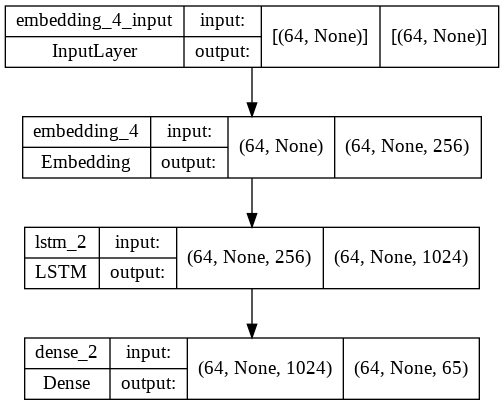

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

# Try the model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [ ]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-1.2918976e-03  1.7753016e-03  4.2673550e-03  6.8023996e-03
 -1.6359934e-03 -5.2476994e-04 -3.7719742e-03 -8.4491093e-03
 -2.8418081e-03 -2.7947458e-03 -3.7838658e-04 -3.4418568e-04
 -3.8866379e-04  5.2690427e-03 -5.2577867e-03  1.3491455e-03
 -6.7760737e-04  2.3427815e-03  4.0552160e-03  4.9938438e-03
 -2.6059493e-03 -1.8732452e-03  4.2147003e-05 -6.6592020e-04
 -1.6933877e-03 -3.1797131e-04 -2.0144943e-03 -4.5179646e-04
 -4.6384786e-04 -1.5555152e-03  7.3139078e-04 -4.7188636e-04
  9.7546098e-04  3.3669216e-03  1.5444370e-03  3.9736130e-03
  2.7296557e-03  5.0230249e-04 -7.8602564e-03 -5.5676891e-04
  4.1527243e-04  1.5344542e-03 -4.7822883e-03  1.0763292e-03
  7.4560335e-04 -5.6853537e-03  5.1654521e-03 -5.9035365e-03
  3.0410332e-03  4.5664012e-03 -2.1867258e-03  4.5540635e-03
  1.2675879e-03  4.6703385e-04  3.7674424e-03  4.4613094e-03
  5.8117057e-03 -2.5843643e-03  5.6413384e-03 -3.9221416e-03
  3.8376329e-03  

In [ ]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 2 2]], shape=(1, 5), dtype=int64)


In [ ]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([100, 1])

In [ ]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(100,)

In [ ]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 "ong live Henry, fourth of that name!\n\nHENRY BOLINGBROKE:\nIn God's name, I'll ascend the regal throne"

Next char prediction:
 "nc'dRCyJc\nOryPShVrkeF!fOabfSbGobHATI-ZXnSPMbF!sExl&$U-W;gxiOZHJt?oOyW$?ShC.mQihcXXxHHMBe!Uk&sRhkVY\nQ"


In [ ]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction {:2d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))

Prediction  0
  input: 53 ('o')
  next predicted: 1 ('n')
Prediction  1
  input: 52 ('n')
  next predicted: 1 ('c')
Prediction  2
  input: 45 ('g')
  next predicted: 1 ("'")
Prediction  3
  input: 1 (' ')
  next predicted: 1 ('d')
Prediction  4
  input: 50 ('l')
  next predicted: 1 ('R')


# Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

## Attach an optimizer, and a loss function

In [ ]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

# example_batch_loss = loss(target_example_batch, example_batch_predictions)

# print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

# Configure checkpoints

In [ ]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

# Execute the training

In [ ]:
EPOCHS=50

In [ ]:
history = model.fit(
  x=dataset,
  epochs=EPOCHS,
  callbacks=[
    checkpoint_callback
  ]
)

Epoch 1/50
172/172 [==============================] - 18s 62ms/step - loss: 2.5903
Epoch 2/50
172/172 [==============================] - 12s 63ms/step - loss: 1.8699
Epoch 3/50
172/172 [==============================] - 12s 63ms/step - loss: 1.6261
Epoch 4/50
172/172 [==============================] - 12s 65ms/step - loss: 1.4962
Epoch 5/50
172/172 [==============================] - 12s 65ms/step - loss: 1.4190
Epoch 6/50
172/172 [==============================] - 13s 67ms/step - loss: 1.3634
Epoch 7/50
172/172 [==============================] - 13s 68ms/step - loss: 1.3193
Epoch 8/50
172/172 [==============================] - 13s 67ms/step - loss: 1.2807
Epoch 9/50
172/172 [==============================] - 12s 65ms/step - loss: 1.2440
Epoch 10/50
172/172 [==============================] - 12s 66ms/step - loss: 1.2097
Epoch 11/50
172/172 [==============================] - 13s 67ms/step - loss: 1.1743
Epoch 12/50
172/172 [==============================] - 13s 67ms/step - loss: 1.1385
E

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

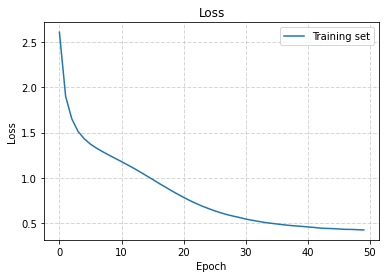

In [ ]:
render_training_history(history)

# Generate text

# Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint.

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

NameError: ignored

In [ ]:
simplified_batch_size = 1

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([simplified_batch_size, None]))

# The prediction loop

The following code block generates the text:


*   It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.
*   Get the prediction distribution of the next character using the start string and the RNN state.

*   Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.
*   The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.







In [ ]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
# Generate the text with default temperature (1.0).
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: but a great danger?

LADY ANNE:
I flamed I, what art thou, And a to me! this is a hope,
That triumph this day and by; Marcius, I
am king by this; and thou his wrathful birth,
Making the hand and sealock.
Will you be so but to know,
Unto the worst degree, by curses; then you wear partice.

DUCHESS OF YORK:
Hadst thou gone already?

ALONSO:
You must need you have:
Yea, arm'd and unpoliar of careless over
That's your where's married with merriest was three danger of his castle:
And I will not tend her to be, 'twere the fairie;
The Volsces were upon York's right: make boast
Of death, my nature; who lies hither are married.

BRUTUS:
We pray now, came news! You wonder, this shall slay them well,
Some trick none of your households
To meet a kind of charity, beg, and Marcius;
Why, this was my write: it is a palt,
'tis but to live in a former language.

AUTOLYCUS:
A fool't not such assistance.

Nurse:
So it be gentlemen.

Clown:
Thou art a traitor with his netsivil neglected
That valiant

In [ ]:
# Generate the text with higher temperature to get more unexpected results.
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.5))

ROMEO: God's in man
Are you go to the marvellous body to roce
But O, my mistress, if thou hast a caid,
And telling whilst I like you, false lord.

QUEEN MARGAREThan to redeem it.
Sirrah, it is amazed: stand ne nobless
Not jays please thee.

QUEEN ELIZABETH:
It is my dealour hot heaven?
Shall I be plebrideonied to Am up.
Your way our country, is holp to fast
Than that he might love for death: behold, 'tis for you: you must know my mind is Duke of Buckingham.
My very mem: what urge thou hath elder,
We thank his neck or happiness bethen;
And I am leather, ben twelve linening caies, first let herself and these and hand
he island likely pent a pack brought that
For being a cause to quench at myself.

PARIO:
Hust it prest
Gh, dying,
It was report with settle-hou went;
Which, with his ill
Se open many things, shall you think through it agry; ye woe hithook aftend on himself that I in, my
tears and impatient vicely inchange and invethe
king else
For death, a rich either be.

Nurse:
Now, knock 